# Moving average bias correction for road temperature


Using a simple moving average approach for bias correction of road temperature on specific stations

In [1]:

import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #bb
from sklearn import linear_model


import matplotlib.pyplot as plt

# no need for these here
#Import a tool for helping make figures
#from climetlab_mltc_surface_observation_postprocessing.utils import imgBufferFromVectors

# CliMetLab will be used to manage the data loading.
#import climetlab as cml


import pandas as pd
import sqlite3
import os

### Read the data and calculate the bias

In [4]:
DATADIR="/media/cap/extra_work/data/road_model"
#df_glat=pd.read_csv(os.path.join(DATADIR,"TROAD_glatmodel_data.csv.gz"),compression="gzip")
df_glat=pd.read_csv(os.path.join(DATADIR,"FYN_TROAD_glatmodel_data.csv.gz"))


#in old dataset named obs_temp, TROAD in new
#obs_temp_array = df_glat["obs_temp"].values.reshape(-1, 1)
obs_temp_array = df_glat["TROAD"].values.reshape(-1, 1)
forecast_temp_array = df_glat["forecast_temp"].values.reshape(-1, 1)

# Convert the "obs_temp" column to a NumPy array with shape (544920, 1)
obs_temp_array = df_glat["TROAD"].values.reshape(-1, 1)

# Calculate the bias (forecast_temp - obs_temp)
forecast_error = forecast_temp_array - obs_temp_array
df_glat["validity_time"] = pd.to_datetime(df_glat["validity_time"])


### A few steps that might be unnecessary later on (datetimes processin) but leaving them here for the moment

In [5]:

df_glat['unix_timestamp'] = (df_glat['validity_time'].values.astype(np.int64) / 1e9)
#df_glat["unix_timestamp"]

In [6]:
#time_of_day = df_glat["unix_timestamp"].values.reshape(-1,1)
#time_of_day
time_of_day = df_glat["lead_hrs"].values.reshape(-1,1)

In [7]:
# Add the information from the lat, lon and height as well as the 2m temperature
con = sqlite3.connect("/media/cap/extra_work/data/road_model/stations_coords_height.db")

query="SELECT * FROM roadstations;"
df_geo = pd.read_sql(query, con)
con.close()
df_geo.rename(columns={"SID":"site_ID"},inplace=True)

#df_geo

df_merged = pd.merge(df_glat, df_geo, on='site_ID', how='left')
#df_glat
#df_geo = df_geo.rename({"SID":"site_ID"},inplace=True)
#df_geo
#df_coords = pd.read_csv()

In [54]:
#df_merged.drop(columns=["forecast_temp"],inplace=True)
df_merged.drop(columns=["TROAD","model_type","model_ID"],inplace=True)

In [9]:
df_merged

,site_ID,model_type,model_ID,init_time,validity_time,lead_hrs,forecast_temp,TROAD,unix_timestamp,lon,lat,height
0,302400,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 06:00:00+00:00,6,7.30,8.20000,1.673417e+09,10.159734,55.400246,70.643433
1,302400,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 12:00:00+00:00,12,8.22,9.60000,1.673438e+09,10.159734,55.400246,70.643433
2,302400,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 18:00:00+00:00,18,4.80,5.90000,1.673460e+09,10.159734,55.400246,70.643433
3,302400,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-12 00:00:00+00:00,24,5.34,6.00000,1.673482e+09,10.159734,55.400246,70.643433
4,302400,glatmodel,glatmodel,2023-01-12T00:00:00Z,2023-01-12 06:00:00+00:00,6,4.51,5.00000,1.673503e+09,10.159734,55.400246,70.643433
...,...,...,...,...,...,...,...,...,...,...,...,...
559497,991000,glatmodel,glatmodel,2023-03-29T23:00:00Z,2023-03-30 17:00:00+00:00,18,9.35,12.50920,1.680196e+09,10.828761,55.302197,8.428855
559498,991000,glatmodel,glatmodel,2023-03-29T23:00:00Z,2023-03-30 23:00:00+00:00,24,7.67,8.58974,1.680217e+09,10.828761,55.302197,8.428855
559499,991000,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 05:00:00+00:00,6,8.35,8.11355,1.680239e+09,10.828761,55.302197,8.428855
559500,991000,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 11:00:00+00:00,12,10.58,12.50920,1.680260e+09,10.828761,55.302197,8.428855


In [10]:
df_merged.dtypes

site_ID                         int64
model_type                     object
model_ID                       object
init_time                      object
validity_time     datetime64[ns, UTC]
lead_hrs                        int64
forecast_temp                 float64
TROAD                         float64
unix_timestamp                float64
lon                           float64
lat                           float64
height                        float64
dtype: object

In [11]:
# Calculate mean error
mean_error = np.mean(forecast_temp_array - obs_temp_array)

In [12]:
#test to check shape of arrays
#forecast_data = np.random.normal(loc=18, scale=6, size=30)  # Sample forecast data
#forecast_data

In [13]:
forecast_temp_array[:,0]

array([ 7.3 ,  8.22,  4.8 , ...,  8.35, 10.58, 10.44])

In [14]:
# Apply moving average to forecast data
#this uses a non weighted moving average
window_size = 3  # Example window size, using 3 hours in this case
smoothed_forecast = np.convolve(forecast_temp_array[:,0], np.ones(window_size)/window_size, mode='valid')


In [15]:
smoothed_forecast

array([6.77333333, 6.12      , 4.88333333, ..., 8.45666667, 8.86666667,
       9.79      ])

In [16]:
np.ones(window_size)/window_size

array([0.33333333, 0.33333333, 0.33333333])

In [17]:
# Adjust forecast by adding mean error to smoothed forecast
corrected_forecast = smoothed_forecast + mean_error

# Print the mean error and corrected forecast
print("Mean Error:", mean_error)
print("Corrected Forecast (Adjusted by Mean Error):", corrected_forecast)

Mean Error: -0.11931223647091518
Corrected Forecast (Adjusted by Mean Error): [6.6540211  6.00068776 4.7640211  ... 8.33735443 8.74735443 9.67068776]


In [18]:
smoothed_forecast.shape

(559500,)

In [19]:
obs_temp_array[:,0].shape

(559502,)

In [20]:
initial_mean_error = np.mean(forecast_temp_array - obs_temp_array)


In [21]:
initial_mean_error

-0.11931223647091518

In [22]:
final_mean_error = np.mean(smoothed_forecast - obs_temp_array[:len(smoothed_forecast),0])


In [23]:
final_mean_error

-0.1193026426510875

In [28]:
# Selecting one station in Fyn:
SID_sel = 335100
#SID_sel = 100001


In [29]:
df_sel = df_glat[df_glat["site_ID"] == SID_sel]


In [30]:
df_sel

,site_ID,model_type,model_ID,init_time,validity_time,lead_hrs,forecast_temp,TROAD,unix_timestamp
3358,335100,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 06:00:00+00:00,6,7.32,7.6,1.673417e+09
3359,335100,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 12:00:00+00:00,12,8.47,7.7,1.673438e+09
3360,335100,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 18:00:00+00:00,18,5.15,4.4,1.673460e+09
3361,335100,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-12 00:00:00+00:00,24,5.89,5.3,1.673482e+09
3362,335100,glatmodel,glatmodel,2023-01-12T00:00:00Z,2023-01-12 06:00:00+00:00,6,4.94,3.3,1.673503e+09
...,...,...,...,...,...,...,...,...,...
555709,335100,glatmodel,glatmodel,2023-03-29T23:00:00Z,2023-03-30 17:00:00+00:00,18,9.12,9.7,1.680196e+09
555710,335100,glatmodel,glatmodel,2023-03-29T23:00:00Z,2023-03-30 23:00:00+00:00,24,7.90,7.6,1.680217e+09
555711,335100,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 05:00:00+00:00,6,7.99,7.2,1.680239e+09
555712,335100,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 11:00:00+00:00,12,12.69,14.0,1.680260e+09


In [31]:
df_sel.drop(columns=["site_ID","model_type","model_ID"],inplace=True)

/tmp/ipykernel_39422/121824800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.drop(columns=["site_ID","model_type","model_ID"],inplace=True)


In [32]:
df_sel

,init_time,validity_time,lead_hrs,forecast_temp,TROAD,unix_timestamp
3358,2023-01-11T00:00:00Z,2023-01-11 06:00:00+00:00,6,7.32,7.6,1.673417e+09
3359,2023-01-11T00:00:00Z,2023-01-11 12:00:00+00:00,12,8.47,7.7,1.673438e+09
3360,2023-01-11T00:00:00Z,2023-01-11 18:00:00+00:00,18,5.15,4.4,1.673460e+09
3361,2023-01-11T00:00:00Z,2023-01-12 00:00:00+00:00,24,5.89,5.3,1.673482e+09
3362,2023-01-12T00:00:00Z,2023-01-12 06:00:00+00:00,6,4.94,3.3,1.673503e+09
...,...,...,...,...,...,...
555709,2023-03-29T23:00:00Z,2023-03-30 17:00:00+00:00,18,9.12,9.7,1.680196e+09
555710,2023-03-29T23:00:00Z,2023-03-30 23:00:00+00:00,24,7.90,7.6,1.680217e+09
555711,2023-03-30T23:00:00Z,2023-03-31 05:00:00+00:00,6,7.99,7.2,1.680239e+09
555712,2023-03-30T23:00:00Z,2023-03-31 11:00:00+00:00,12,12.69,14.0,1.680260e+09


### Using moving average correction for specific stations

In [33]:
#Want to use a separate MA for each forecast cycle
df_sel["init_time"] = pd.to_datetime(df_sel["init_time"])

/tmp/ipykernel_39422/1767574826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["init_time"] = pd.to_datetime(df_sel["init_time"])


In [34]:
df_sel["init_time"].values[0]

numpy.datetime64('2023-01-11T00:00:00.000000000')

In [35]:
df_cy_00 = df_sel[df_sel['init_time'].dt.hour == 0]
df_cy_00

,init_time,validity_time,lead_hrs,forecast_temp,TROAD,unix_timestamp
3358,2023-01-11 00:00:00+00:00,2023-01-11 06:00:00+00:00,6,7.32,7.6,1.673417e+09
3359,2023-01-11 00:00:00+00:00,2023-01-11 12:00:00+00:00,12,8.47,7.7,1.673438e+09
3360,2023-01-11 00:00:00+00:00,2023-01-11 18:00:00+00:00,18,5.15,4.4,1.673460e+09
3361,2023-01-11 00:00:00+00:00,2023-01-12 00:00:00+00:00,24,5.89,5.3,1.673482e+09
3362,2023-01-12 00:00:00+00:00,2023-01-12 06:00:00+00:00,6,4.94,3.3,1.673503e+09
...,...,...,...,...,...,...
352239,2023-03-30 00:00:00+00:00,2023-03-30 18:00:00+00:00,18,8.46,8.7,1.680199e+09
352240,2023-03-30 00:00:00+00:00,2023-03-31 00:00:00+00:00,24,7.95,7.5,1.680221e+09
352241,2023-03-31 00:00:00+00:00,2023-03-31 06:00:00+00:00,6,8.30,7.5,1.680242e+09
352242,2023-03-31 00:00:00+00:00,2023-03-31 12:00:00+00:00,12,14.38,14.0,1.680264e+09


In [40]:
df_cy_01 = df_sel[df_sel['init_time'].dt.hour == 1]
df_cy_01

,init_time,validity_time,lead_hrs,forecast_temp,TROAD,unix_timestamp
9517,2023-01-11 01:00:00+00:00,2023-01-11 07:00:00+00:00,6,7.61,7.8,1.673420e+09
9518,2023-01-11 01:00:00+00:00,2023-01-11 13:00:00+00:00,12,8.55,7.7,1.673442e+09
9519,2023-01-11 01:00:00+00:00,2023-01-11 19:00:00+00:00,18,5.78,5.0,1.673464e+09
9520,2023-01-11 01:00:00+00:00,2023-01-12 01:00:00+00:00,24,5.55,4.3,1.673485e+09
9521,2023-01-12 01:00:00+00:00,2023-01-12 07:00:00+00:00,6,5.05,3.9,1.673507e+09
...,...,...,...,...,...,...
361197,2023-03-30 01:00:00+00:00,2023-03-30 19:00:00+00:00,18,8.34,8.2,1.680203e+09
361198,2023-03-30 01:00:00+00:00,2023-03-31 01:00:00+00:00,24,7.91,7.5,1.680224e+09
361199,2023-03-31 01:00:00+00:00,2023-03-31 07:00:00+00:00,6,9.37,9.1,1.680246e+09
361200,2023-03-31 01:00:00+00:00,2023-03-31 13:00:00+00:00,12,13.76,14.5,1.680268e+09


### Correction for cycle 00

In [41]:
df_cy_00.dtypes

init_time         datetime64[ns, UTC]
validity_time     datetime64[ns, UTC]
lead_hrs                        int64
forecast_temp                 float64
TROAD                         float64
unix_timestamp                float64
dtype: object

In [43]:
# Calculate the error between forecasted and observed temperatures
df_cy_00['error'] = df_cy_00['forecast_temp'] - df_cy_00['TROAD']

# Function to calculate mean error over a rolling window
def calculate_mean_error(df, window_size):
    df['mean_error'] = df.groupby('lead_hrs')['error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    return df

# Specify the window size (e.g., 3 days)
window_size = 3

# Calculate the mean error over the specified window
df_with_mean_error = calculate_mean_error(df_cy_00, window_size)

# Extract the most recent mean error for the current forecast
current_forecast_mean_error = df_with_mean_error.groupby('lead_hrs').tail(1)

df_with_mean_error['corrected_forecast_temp'] = df_with_mean_error['forecast_temp'] - df_with_mean_error['mean_error']

#print(df_with_mean_error)
#print("\nCurrent Forecast Mean Error:\n", current_forecast_mean_error)

/tmp/ipykernel_39422/1341254762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cy_00['error'] = df_cy_00['forecast_temp'] - df_cy_00['TROAD']
/tmp/ipykernel_39422/1341254762.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_error'] = df.groupby('lead_hrs')['error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
/tmp/ipykernel_39422/1341254762.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

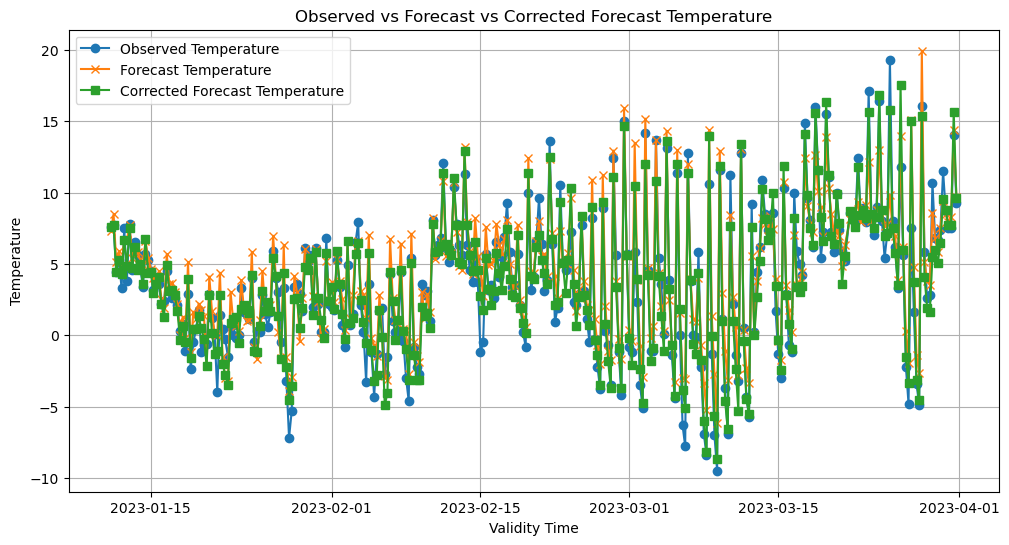

In [45]:
# Plotting the time series
plt.figure(figsize=(12, 6))

plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['TROAD'], label='Observed Temperature', marker='o')
plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['forecast_temp'], label='Forecast Temperature', marker='x')
plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['corrected_forecast_temp'], label='Corrected Forecast Temperature', marker='s')

plt.xlabel('Validity Time')
plt.ylabel('Temperature')
plt.title('Observed vs Forecast vs Corrected Forecast Temperature')
plt.legend()
plt.grid(True)
plt.show()

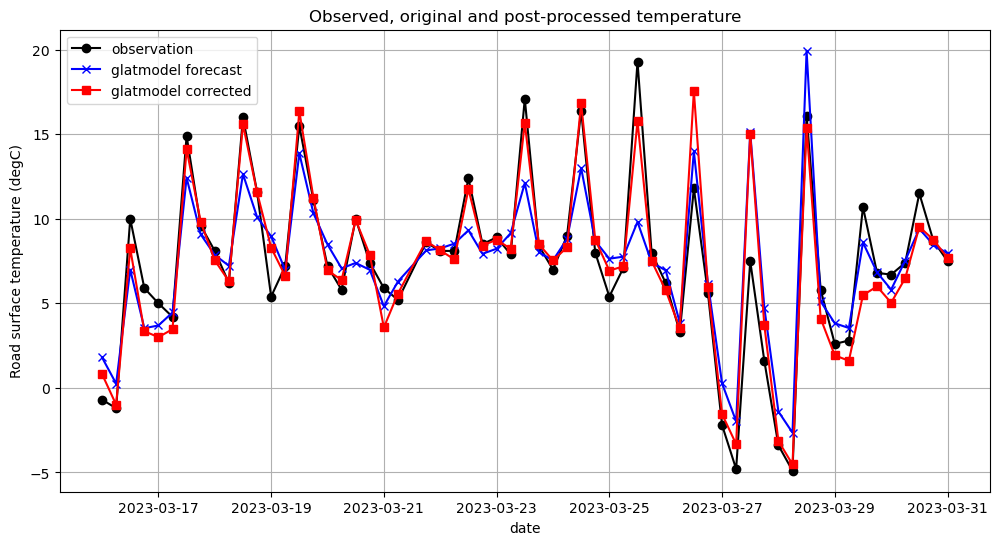

In [50]:
### Plot only a particular date range

# Specify the date range to filter
start_date = '2023-03-16'
end_date = '2023-03-31'

# Filter the DataFrame to the specified date range
mask = (df_with_mean_error['validity_time'] >= start_date) & (df_with_mean_error['validity_time'] <= end_date)
filtered_df = df_with_mean_error[mask]

# Plotting the bias before and after correction for the filtered date range
plt.figure(figsize=(12, 6))

plt.plot(filtered_df['validity_time'], filtered_df['TROAD'], label='observation', marker='o',color="black")
plt.plot(filtered_df['validity_time'], filtered_df['forecast_temp'], label='glatmodel forecast', marker='x',color="blue")
plt.plot(filtered_df['validity_time'], filtered_df['corrected_forecast_temp'], label='glatmodel corrected', marker='s',color="red")


plt.xlabel('date')
plt.ylabel('Road surface temperature (degC)')
plt.title('Observed, original and post-processed temperature')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_39422/2477647899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_mean_error['corrected_error'] = df_with_mean_error['corrected_forecast_temp'] - df_with_mean_error['TROAD']


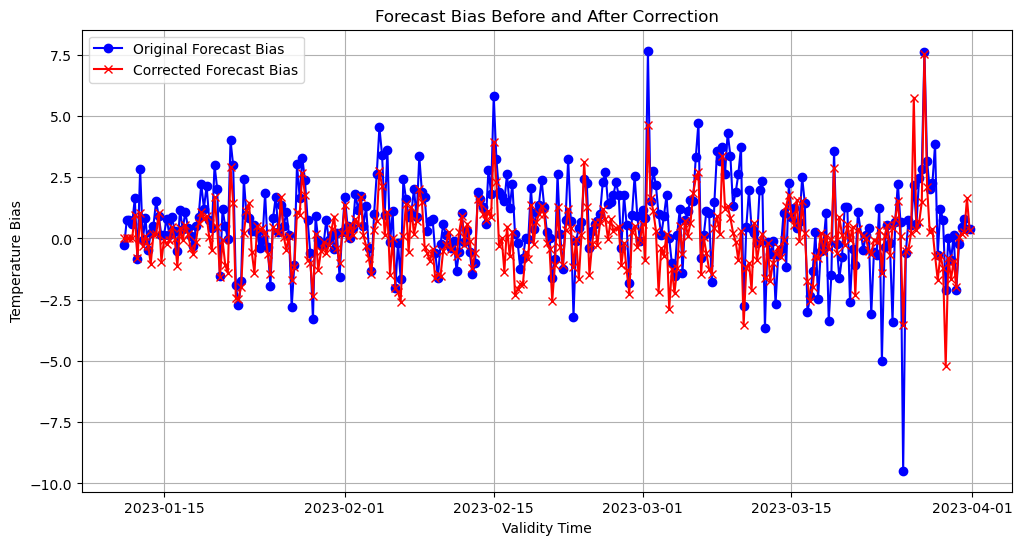

In [51]:
# Calculate the corrected error (bias) after correction
df_with_mean_error['corrected_error'] = df_with_mean_error['corrected_forecast_temp'] - df_with_mean_error['TROAD']

# Plotting the bias before and after correction
plt.figure(figsize=(12, 6))

plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['error'], label='Original Forecast Bias', marker='o',color="blue")
plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['corrected_error'], label='Corrected Forecast Bias', marker='x',color="red")

plt.xlabel('Validity Time')
plt.ylabel('Temperature Bias')
plt.title('Forecast Bias Before and After Correction')
plt.legend()
plt.grid(True)
plt.show()

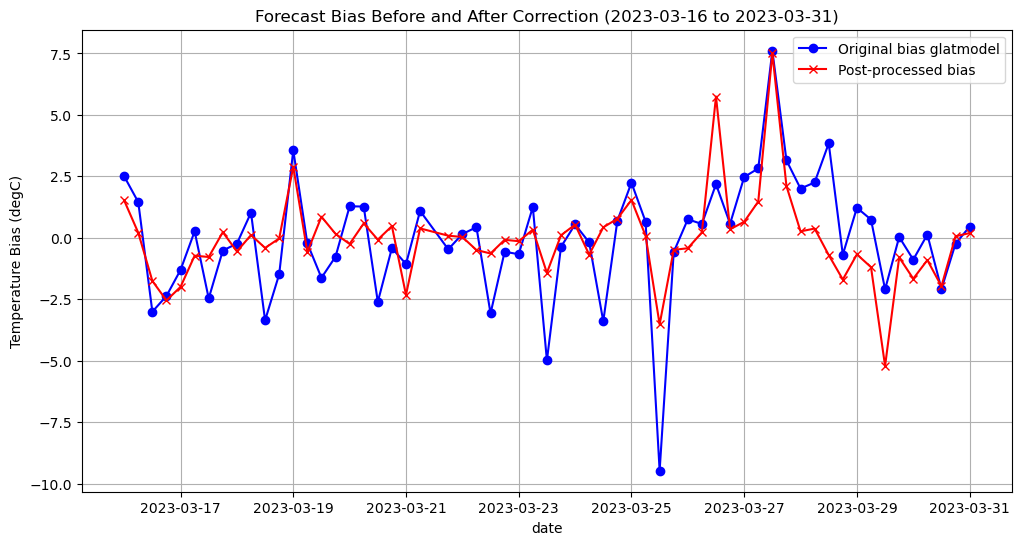

In [53]:
### Plot only a particular date range

# Specify the date range to filter
start_date = '2023-03-16'
end_date = '2023-03-31'

# Filter the DataFrame to the specified date range
mask = (df_with_mean_error['validity_time'] >= start_date) & (df_with_mean_error['validity_time'] <= end_date)
filtered_df = df_with_mean_error[mask]

# Plotting the bias before and after correction for the filtered date range
plt.figure(figsize=(12, 6))

plt.plot(filtered_df['validity_time'], filtered_df['error'], label='Original bias glatmodel', marker='o',color="blue")
plt.plot(filtered_df['validity_time'], filtered_df['corrected_error'], label='Post-processed bias', marker='x',color="red")

plt.xlabel('date')
plt.ylabel('Temperature Bias (degC)')
plt.title(f'Forecast Bias Before and After Correction ({start_date} to {end_date})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# I want to calculate the error only for the period shown


In [60]:
# Function to calculate RMSE
from datetime import datetime
import pytz

test_start_date = datetime.strptime('2023-03-16', '%Y-%m-%d').replace(tzinfo=pytz.UTC)
test_end_date = datetime.strptime('2023-03-31','%Y-%m-%d').replace(tzinfo=pytz.UTC)
test_df = df_with_mean_error[(df_with_mean_error['validity_time'] >= test_start_date) & (df_with_mean_error['validity_time'] <= test_end_date)]

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Group by lead_hrs and calculate RMSE for each group
rmse_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    rmse_original = calculate_rmse(group['TROAD'], group['forecast_temp'])
    rmse_model = calculate_rmse(group['TROAD'], group['corrected_forecast_temp'])
    rmse_results.append((lead_hr, rmse_original, rmse_model))

# Convert results to a DataFrame for better readability
rmse_df = pd.DataFrame(rmse_results, columns=['lead_hrs', 'RMSE_Original', 'RMSE_Model'])



#print(rmse_df)


# Function to calculate bias (mean error)
def calculate_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Group by lead_hrs and calculate bias for each group
bias_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    bias_original = calculate_bias(group['TROAD'], group['forecast_temp'])
    bias_model = calculate_bias(group['TROAD'], group['corrected_forecast_temp'])
    bias_results.append((lead_hr, bias_original, bias_model))

# Convert results to a DataFrame for better readability
bias_df = pd.DataFrame(bias_results, columns=['lead_hrs', 'Bias_Original', 'Bias_Model'])

#print(bias_df)

errors_df = pd.DataFrame({"lead_hr": rmse_df.lead_hrs,"RMSE_orig":rmse_df.RMSE_Original, "RMSE_pp":rmse_df.RMSE_Model,
                          "bias_orig":bias_df.Bias_Original,"bias_pp":bias_df.Bias_Model})

In [61]:
errors_df

,lead_hr,RMSE_orig,RMSE_pp,bias_orig,bias_pp
0,6,1.215908,0.676279,-0.900667,0.056667
1,12,4.292225,3.169433,1.756429,0.141667
2,18,1.187544,1.024505,0.270000,0.089111
3,24,1.628028,1.300240,-0.811250,0.027500
